NameError: name 'v' is not defined

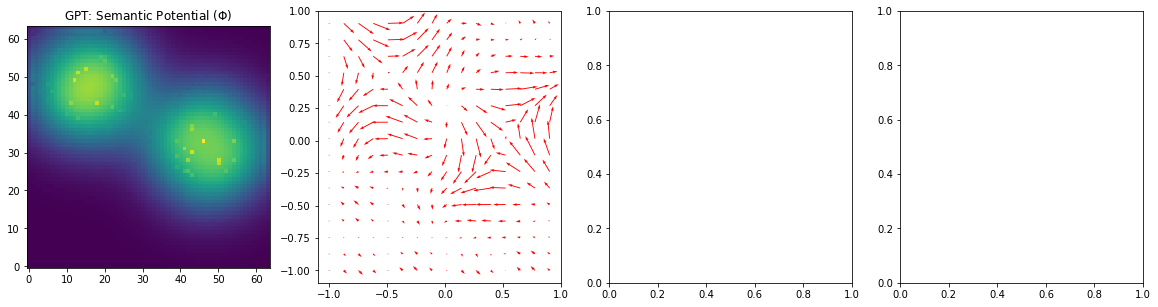

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Simulation parameters
nx, ny = 64, 64
Lx, Ly = 2.0, 2.0
dx, dy = Lx / (nx - 1), Ly / (ny - 1)
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
X, Y = np.meshgrid(x, y)
dt = 0.01
n_steps = 50  # Reduced for faster debugging
beta = 0.1
output_dir = "rsvp_visuals"
os.makedirs(output_dir, exist_ok=True)

# Initialize fields
phi = np.exp(-5 * ((X - 0.5)**2 + Y**2)) + np.exp(-5 * ((X + 0.5)**2 + (Y - 0.5)**2))
vx = np.zeros((nx, ny))
vy = np.zeros((nx, ny))
S = np.ones((nx, ny)) * 0.1
delays = np.random.uniform(0, 0.1, (nx, ny))
torsion_history = {'gpt': [], 'rsvp': []}
fixpoint_history = {'gpt': [], 'rsvp': []}

def compute_v(phi, mode='rsvp'):
    vx = np.zeros_like(phi)
    vy = np.zeros_like(phi)
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            vx[i, j] = -(phi[i+1, j] - phi[i-1, j]) / (2 * dx)
            vy[i, j] = -(phi[i, j+1] - phi[i, j-1]) / (2 * dy)
    if mode == 'gpt':
        noise = 0.5 * np.sin(2 * np.pi * X) * np.cos(2 * np.pi * Y)
        vx += noise
        vy += -noise
    return vx, vy

def compute_entropy_torsion(vx, vy):
    div_v = np.zeros_like(vx)
    curl_v = np.zeros_like(vx)
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            div_v[i, j] = (vx[i+1, j] - vx[i-1, j]) / (2 * dx) + (vy[i, j+1] - vy[i, j-1]) / (2 * dy)
            curl_v[i, j] = (vy[i+1, j] - vy[i-1, j]) / (2 * dx) - (vx[i, j+1] - vx[i, j-1]) / (2 * dy)
    S = 0.5 * np.abs(div_v) + 0.5 * np.abs(curl_v)
    torsion = np.mean(curl_v**2)
    return S, torsion

def compute_fixpoint_stability(phi, vx, vy):
    grad_phi_x = (phi[2:, 1:-1] - phi[:-2, 1:-1]) / (2 * dx)
    grad_phi_y = (phi[1:-1, 2:] - phi[1:-1, :-2]) / (2 * dy)
    alignment = np.mean((vx[1:-1, 1:-1] - grad_phi_x)**2 + (vy[1:-1, 1:-1] - grad_phi_y)**2)
    return alignment

def update_fields(phi, vx, vy, S, mode='rsvp'):
    phi_new = phi.copy()
    S_new = S.copy()
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            if np.random.random() > delays[i, j]:
                flux = phi[i, j] * ((vx[i+1, j] - vx[i-1, j]) / (2 * dx) + (vy[i, j+1] - vy[i, j-1]) / (2 * dy))
                dS_dt = -0.5 * np.linalg.norm([vx[i, j] - (-(phi[i+1, j] - phi[i-1, j]) / (2 * dx)), 
                                               vy[i, j] - (-(phi[i, j+1] - phi[i, j-1]) / (2 * dy))])**2
                phi_new[i, j] -= dt * flux
                S_new[i, j] += dt * dS_dt
    return phi_new, S_new

# Simulate and save individual frames
modes = ['gpt', 'rsvp']
fields = {'gpt': (phi.copy(), vx.copy(), vy.copy(), S.copy()), 'rsvp': (phi.copy(), vx.copy(), vy.copy(), S.copy())}

for t in range(n_steps):
    for mode in modes:
        phi, vx, vy, S = fields[mode]
        vx, vy = compute_v(phi, mode=mode)
        phi, S = update_fields(phi, vx, vy, S, mode=mode)
        S, torsion = compute_entropy_torsion(vx, vy)
        fixpoint = compute_fixpoint_stability(phi, vx, vy)
        fields[mode] = (phi, vx, vy, S)
        torsion_history[mode].append(torsion)
        fixpoint_history[mode].append(fixpoint)

        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        axes[0].imshow(phi, cmap='viridis', origin='lower')
        axes[0].set_title(f'{mode.upper()}: Semantic Potential ($\Phi$)')
        axes[1].quiver(X[::4, ::4], Y[::4, ::4], vx[::4, ::4], vy[::4, ::4], color='blue' if mode == 'rsvp' else 'red')
        axes[1].set_title(f'{mode.upper()}: Semantic Flow ($\vec{v}$)')
        axes[2].imshow(S, cmap='inferno', origin='lower')
        axes[2].set_title(f'{mode.upper()}: Entropy ($\mathcal{S}$)')
        axes[3].imshow(np.abs(vx[1:-1, 1:-1] - (phi[2:, 1:-1] - phi[:-2, 1:-1]) / (2 * dx)), cmap='magma', origin='lower')
        axes[3].set_title(f'{mode.upper()}: Flow Misalignment')
        for ax in axes:
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()
        plt.savefig(f"{output_dir}/{mode}_frame_{t:03d}.png")
        plt.close()

# Static convergence chart
plt.figure(figsize=(10, 6))
plt.plot(torsion_history['gpt'], label='GPT Torsion', color='#e74c3c')
plt.plot(torsion_history['rsvp'], label='RSVP Torsion', color='#3498db')
plt.plot(fixpoint_history['gpt'], label='GPT Fixpoint Misalignment', color='#c0392b')
plt.plot(fixpoint_history['rsvp'], label='RSVP Fixpoint Misalignment', color='#2980b9')
plt.title('RSVP vs GPT: Torsion and Fixpoint Convergence')
plt.xlabel('Time Step')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.savefig(f"{output_dir}/convergence_chart.png")
plt.close()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

# Check LaTeX availability
matplotlib.rcParams['text.usetex'] = False  # Disable LaTeX to avoid parsing errors
print("Matplotlib backend:", matplotlib.get_backend())
print("Saving visuals to 'rsvp_visuals/' directory...")

# Simulation parameters
nx, ny = 64, 64
Lx, Ly = 2.0, 2.0
dx, dy = Lx / (nx - 1), Ly / (ny - 1)
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
X, Y = np.meshgrid(x, y)
dt = 0.01
n_steps = 20  # Shortened for quick testing
beta = 0.1
output_dir = "rsvp_visuals"
os.makedirs(output_dir, exist_ok=True)

# Initialize fields
phi = np.exp(-5 * ((X - 0.5)**2 + Y**2)) + np.exp(-5 * ((X + 0.5)**2 + (Y - 0.5)**2))
vx = np.zeros((nx, ny))
vy = np.zeros((nx, ny))
S = np.ones((nx, ny)) * 0.1
delays = np.random.uniform(0, 0.1, (nx, ny))
torsion_history = {'gpt': [], 'rsvp': []}
fixpoint_history = {'gpt': [], 'rsvp': []}

def compute_v(phi, mode='rsvp'):
    vx = np.zeros_like(phi)
    vy = np.zeros_like(phi)
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            vx[i, j] = -(phi[i+1, j] - phi[i-1, j]) / (2 * dx)
            vy[i, j] = -(phi[i, j+1] - phi[i, j-1]) / (2 * dy)
    if mode == 'gpt':
        noise = 0.5 * np.sin(2 * np.pi * X) * np.cos(2 * np.pi * Y)
        vx += noise
        vy += -noise
    return vx, vy

def compute_entropy_torsion(vx, vy):
    div_v = np.zeros_like(vx)
    curl_v = np.zeros_like(vx)
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            div_v[i, j] = (vx[i+1, j] - vx[i-1, j]) / (2 * dx) + (vy[i, j+1] - vy[i, j-1]) / (2 * dy)
            curl_v[i, j] = (vy[i+1, j] - vy[i-1, j]) / (2 * dx) - (vx[i, j+1] - vx[i, j-1]) / (2 * dy)
    S = 0.5 * np.abs(div_v) + 0.5 * np.abs(curl_v)
    torsion = np.mean(curl_v**2)
    return S, torsion

def compute_fixpoint_stability(phi, vx, vy):
    grad_phi_x = (phi[2:, 1:-1] - phi[:-2, 1:-1]) / (2 * dx)
    grad_phi_y = (phi[1:-1, 2:] - phi[1:-1, :-2]) / (2 * dy)
    alignment = np.mean((vx[1:-1, 1:-1] - grad_phi_x)**2 + (vy[1:-1, 1:-1] - grad_phi_y)**2)
    return alignment

def update_fields(phi, vx, vy, S, mode='rsvp'):
    phi_new = phi.copy()
    S_new = S.copy()
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            if np.random.random() > delays[i, j]:
                flux = phi[i, j] * ((vx[i+1, j] - vx[i-1, j]) / (2 * dx) + (vy[i, j+1] - vy[i, j-1]) / (2 * dy))
                dS_dt = -0.5 * np.linalg.norm([vx[i, j] - (-(phi[i+1, j] - phi[i-1, j]) / (2 * dx)), 
                                               vy[i, j] - (-(phi[i, j+1] - phi[i, j-1]) / (2 * dy))])**2
                phi_new[i, j] -= dt * flux
                S_new[i, j] += dt * dS_dt
    return phi_new, S_new

# Simulate and save individual frames
modes = ['gpt', 'rsvp']
fields = {'gpt': (phi.copy(), vx.copy(), vy.copy(), S.copy()), 'rsvp': (phi.copy(), vx.copy(), vy.copy(), S.copy())}

for t in range(n_steps):
    for mode in modes:
        phi, vx, vy, S = fields[mode]
        vx, vy = compute_v(phi, mode=mode)
        phi, S = update_fields(phi, vx, vy, S, mode=mode)
        S, torsion = compute_entropy_torsion(vx, vy)
        fixpoint = compute_fixpoint_stability(phi, vx, vy)
        fields[mode] = (phi, vx, vy, S)
        torsion_history[mode].append(torsion)
        fixpoint_history[mode].append(fixpoint)

        # Individual plot rendering to avoid crashes
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        try:
            # Semantic Potential
            axes[0].imshow(phi, cmap='viridis', origin='lower')
            axes[0].set_title(f'{mode.upper()}: Semantic Potential (Phi)')
            axes[0].set_xticks([])
            axes[0].set_yticks([])

            # Semantic Flow
            axes[1].quiver(X[::4, ::4], Y[::4, ::4], vx[::4, ::4], vy[::4, ::4], color='blue' if mode == 'rsvp' else 'red')
            axes[1].set_title(f'{mode.upper()}: Semantic Flow (v)')
            axes[1].set_xticks([])
            axes[1].set_yticks([])

            # Entropy
            axes[2].imshow(S, cmap='inferno', origin='lower')
            axes[2].set_title(f'{mode.upper()}: Entropy (S)')
            axes[2].set_xticks([])
            axes[2].set_yticks([])

            # Flow Misalignment
            misalignment = np.abs(vx[1:-1, 1:-1] - (phi[2:, 1:-1] - phi[:-2, 1:-1]) / (2 * dx))
            axes[3].imshow(misalignment, cmap='magma', origin='lower')
            axes[3].set_title(f'{mode.upper()}: Flow Misalignment')
            axes[3].set_xticks([])
            axes[3].set_yticks([])

            plt.tight_layout()
            plt.savefig(f"{output_dir}/{mode}_frame_{t:03d}.png")
            print(f"Saved {mode}_frame_{t:03d}.png")
        except Exception as e:
            print(f"Error rendering {mode} frame {t}: {e}")
        finally:
            plt.close()

# Static convergence chart
plt.figure(figsize=(10, 6))
plt.plot(torsion_history['gpt'], label='GPT Torsion', color='#e74c3c')
plt.plot(torsion_history['rsvp'], label='RSVP Torsion', color='#3498db')
plt.plot(fixpoint_history['gpt'], label='GPT Fixpoint Misalignment', color='#c0392b')
plt.plot(fixpoint_history['rsvp'], label='RSVP Fixpoint Misalignment', color='#2980b9')
plt.title('RSVP vs GPT: Torsion and Fixpoint Convergence')
plt.xlabel('Time Step')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.savefig(f"{output_dir}/convergence_chart.png")
print(f"Saved convergence_chart.png")
plt.close()

print(f"All visuals saved in {output_dir}/")

Matplotlib backend: module://ipykernel.pylab.backend_inline
Saving visuals to 'rsvp_visuals/' directory...
Saved gpt_frame_000.png
Saved rsvp_frame_000.png
Saved gpt_frame_001.png
Saved rsvp_frame_001.png
Saved gpt_frame_002.png
Saved rsvp_frame_002.png
Saved gpt_frame_003.png
Saved rsvp_frame_003.png
Saved gpt_frame_004.png
Saved rsvp_frame_004.png
Saved gpt_frame_005.png
Saved rsvp_frame_005.png
Saved gpt_frame_006.png
Saved rsvp_frame_006.png
Saved gpt_frame_007.png
Saved rsvp_frame_007.png


<ipython-input-6-7676093f7593>:60: RuntimeWarning: overflow encountered in square
  alignment = np.mean((vx[1:-1, 1:-1] - grad_phi_x)**2 + (vy[1:-1, 1:-1] - grad_phi_y)**2)


Saved gpt_frame_008.png
Saved rsvp_frame_008.png


<ipython-input-6-7676093f7593>:69: RuntimeWarning: overflow encountered in double_scalars
  flux = phi[i, j] * ((vx[i+1, j] - vx[i-1, j]) / (2 * dx) + (vy[i, j+1] - vy[i, j-1]) / (2 * dy))
<ipython-input-6-7676093f7593>:58: RuntimeWarning: invalid value encountered in subtract
  grad_phi_x = (phi[2:, 1:-1] - phi[:-2, 1:-1]) / (2 * dx)
<ipython-input-6-7676093f7593>:59: RuntimeWarning: invalid value encountered in subtract
  grad_phi_y = (phi[1:-1, 2:] - phi[1:-1, :-2]) / (2 * dy)
<ipython-input-6-7676093f7593>:113: RuntimeWarning: invalid value encountered in subtract
  misalignment = np.abs(vx[1:-1, 1:-1] - (phi[2:, 1:-1] - phi[:-2, 1:-1]) / (2 * dx))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:455: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:460: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact


Saved gpt_frame_009.png
Saved rsvp_frame_009.png


<ipython-input-6-7676093f7593>:39: RuntimeWarning: invalid value encountered in double_scalars
  vy[i, j] = -(phi[i, j+1] - phi[i, j-1]) / (2 * dy)
<ipython-input-6-7676093f7593>:38: RuntimeWarning: invalid value encountered in double_scalars
  vx[i, j] = -(phi[i+1, j] - phi[i-1, j]) / (2 * dx)
<ipython-input-6-7676093f7593>:70: RuntimeWarning: invalid value encountered in double_scalars
  dS_dt = -0.5 * np.linalg.norm([vx[i, j] - (-(phi[i+1, j] - phi[i-1, j]) / (2 * dx)),
<ipython-input-6-7676093f7593>:72: RuntimeWarning: invalid value encountered in double_scalars
  phi_new[i, j] -= dt * flux
<ipython-input-6-7676093f7593>:71: RuntimeWarning: invalid value encountered in double_scalars
  vy[i, j] - (-(phi[i, j+1] - phi[i, j-1]) / (2 * dy))])**2
<ipython-input-6-7676093f7593>:69: RuntimeWarning: invalid value encountered in double_scalars
  flux = phi[i, j] * ((vx[i+1, j] - vx[i-1, j]) / (2 * dx) + (vy[i, j+1] - vy[i, j-1]) / (2 * dy))
<ipython-input-6-7676093f7593>:52: RuntimeWarning

Saved gpt_frame_010.png
Saved rsvp_frame_010.png


<ipython-input-6-7676093f7593>:51: RuntimeWarning: overflow encountered in double_scalars
  div_v[i, j] = (vx[i+1, j] - vx[i-1, j]) / (2 * dx) + (vy[i, j+1] - vy[i, j-1]) / (2 * dy)
<ipython-input-6-7676093f7593>:52: RuntimeWarning: overflow encountered in double_scalars
  curl_v[i, j] = (vy[i+1, j] - vy[i-1, j]) / (2 * dx) - (vx[i, j+1] - vx[i, j-1]) / (2 * dy)


Saved gpt_frame_011.png
Saved rsvp_frame_011.png
Saved gpt_frame_012.png
Saved rsvp_frame_012.png
Saved gpt_frame_013.png
Saved rsvp_frame_013.png
Saved gpt_frame_014.png
Saved rsvp_frame_014.png
Saved gpt_frame_015.png
Saved rsvp_frame_015.png
Saved gpt_frame_016.png
Saved rsvp_frame_016.png
Saved gpt_frame_017.png
Saved rsvp_frame_017.png
Saved gpt_frame_018.png
Saved rsvp_frame_018.png
Saved gpt_frame_019.png
Saved rsvp_frame_019.png
Saved convergence_chart.png
All visuals saved in rsvp_visuals/


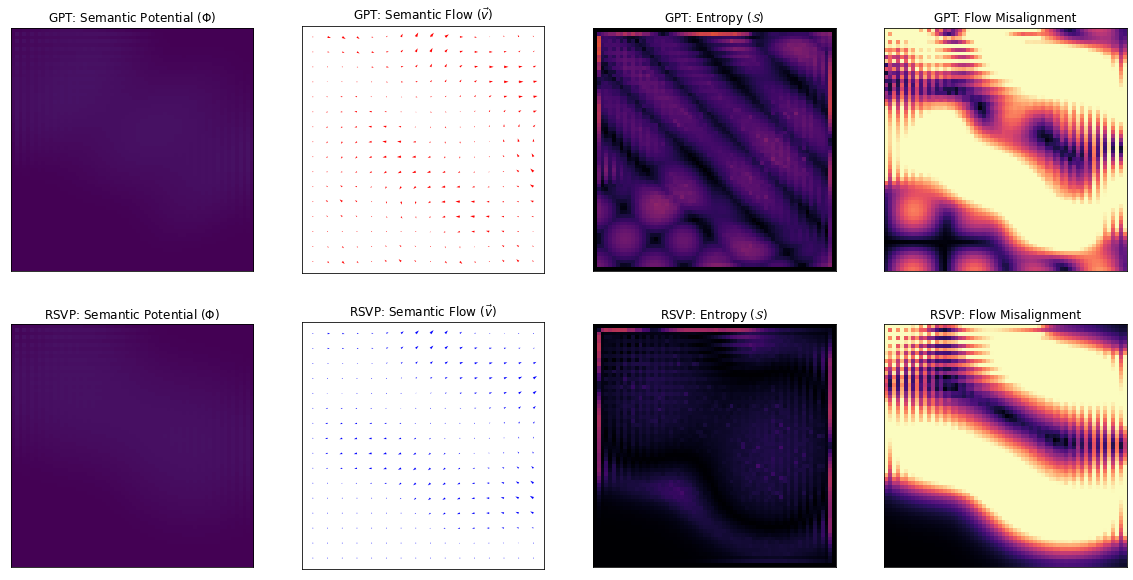

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Simulation parameters
nx, ny = 64, 64
Lx, Ly = 2.0, 2.0
dx, dy = Lx / (nx - 1), Ly / (ny - 1)
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
X, Y = np.meshgrid(x, y)
dt = 0.001  # Reduced time step for stability
n_steps = 150
beta = 0.1  # Torsion penalty

# Initialize fields
phi = np.exp(-5 * ((X - 0.5)**2 + Y**2)) + np.exp(-5 * ((X + 0.5)**2 + (Y - 0.5)**2))
vx = np.zeros((nx, ny))
vy = np.zeros((nx, ny))
S = np.ones((nx, ny)) * 0.1
delays = np.random.uniform(0, 0.1, (nx, ny))  # NCL async delays
fixpoint_history = {'gpt': [], 'rsvp': []}
torsion_history = {'gpt': [], 'rsvp': []}

# Simulation value limits for clipping
PHI_MIN, PHI_MAX = 0, 10
S_MIN, S_MAX = 0, 10

def compute_v(phi, mode='rsvp'):
    vx = np.zeros_like(phi)
    vy = np.zeros_like(phi)
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            vx[i, j] = -(phi[i+1, j] - phi[i-1, j]) / (2 * dx)
            vy[i, j] = -(phi[i, j+1] - phi[i, j-1]) / (2 * dy)
    if mode == 'gpt':
        noise = 0.5 * np.sin(2 * np.pi * X) * np.cos(2 * np.pi * Y)
        vx += noise
        vy += -noise
    # Clip to avoid runaway values
    vx = np.clip(vx, -10, 10)
    vy = np.clip(vy, -10, 10)
    return vx, vy

def compute_entropy_torsion(vx, vy):
    div_v = np.zeros_like(vx)
    curl_v = np.zeros_like(vx)
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            div_v[i, j] = (vx[i+1, j] - vx[i-1, j]) / (2 * dx) + (vy[i, j+1] - vy[i, j-1]) / (2 * dy)
            curl_v[i, j] = (vy[i+1, j] - vy[i-1, j]) / (2 * dx) - (vx[i, j+1] - vx[i, j-1]) / (2 * dy)
    S = 0.5 * np.abs(div_v) + 0.5 * np.abs(curl_v)
    torsion = np.mean(np.square(curl_v))
    # Clean up numerical issues
    S = np.nan_to_num(S, nan=S_MIN, posinf=S_MAX, neginf=S_MIN)
    torsion = np.nan_to_num(torsion, nan=0.0, posinf=1e3, neginf=0.0)
    return S, torsion

def compute_fixpoint_stability(phi, vx, vy):
    grad_phi_x = (phi[2:, 1:-1] - phi[:-2, 1:-1]) / (2 * dx)
    grad_phi_y = (phi[1:-1, 2:] - phi[1:-1, :-2]) / (2 * dy)
    alignment = np.mean((vx[1:-1, 1:-1] - grad_phi_x)**2 + (vy[1:-1, 1:-1] - grad_phi_y)**2)
    alignment = np.nan_to_num(alignment, nan=1e3, posinf=1e3, neginf=1e3)
    return alignment

def update_fields(phi, vx, vy, S, mode='rsvp'):
    phi_new = phi.copy()
    S_new = S.copy()
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            if np.random.random() > delays[i, j]:
                # Compute flux and dS_dt safely
                try:
                    flux = phi[i, j] * ((vx[i+1, j] - vx[i-1, j]) / (2 * dx) + (vy[i, j+1] - vy[i, j-1]) / (2 * dy))
                except:
                    flux = 0.0
                try:
                    v_x_expected = -(phi[i+1, j] - phi[i-1, j]) / (2 * dx)
                    v_y_expected = -(phi[i, j+1] - phi[i, j-1]) / (2 * dy)
                    dS_dt = -0.5 * ( (vx[i, j] - v_x_expected)**2 + (vy[i, j] - v_y_expected)**2 )
                except:
                    dS_dt = 0.0
                phi_new[i, j] -= dt * flux
                S_new[i, j] += dt * dS_dt
    # Clean up and clip for safety
    phi_new = np.nan_to_num(phi_new, nan=PHI_MIN, posinf=PHI_MAX, neginf=PHI_MIN)
    S_new = np.nan_to_num(S_new, nan=S_MIN, posinf=S_MAX, neginf=S_MIN)
    phi_new = np.clip(phi_new, PHI_MIN, PHI_MAX)
    S_new = np.clip(S_new, S_MIN, S_MAX)
    return phi_new, S_new

# Animation setup
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
modes = ['gpt', 'rsvp']
fields = {'gpt': (phi.copy(), vx.copy(), vy.copy(), S.copy()), 
          'rsvp': (phi.copy(), vx.copy(), vy.copy(), S.copy())}

def animate(t):
    for idx, mode in enumerate(modes):
        phi, vx, vy, S = fields[mode]
        vx, vy = compute_v(phi, mode=mode)
        phi, S = update_fields(phi, vx, vy, S, mode=mode)
        S, torsion = compute_entropy_torsion(vx, vy)
        fixpoint = compute_fixpoint_stability(phi, vx, vy)
        fields[mode] = (phi, vx, vy, S)
        torsion_history[mode].append(torsion)
        fixpoint_history[mode].append(fixpoint)

        axes[idx, 0].clear()
        axes[idx, 0].imshow(phi, cmap='viridis', origin='lower', vmin=PHI_MIN, vmax=PHI_MAX)
        axes[idx, 0].set_title(f'{mode.upper()}: Semantic Potential ($\\Phi$)')
        axes[idx, 1].clear()
        axes[idx, 1].quiver(X[::4, ::4], Y[::4, ::4], vx[::4, ::4], vy[::4, ::4],
                            color='blue' if mode == 'rsvp' else 'red', scale=50)
        axes[idx, 1].set_title(f'{mode.upper()}: Semantic Flow ($\\vec{{v}}$)')
        axes[idx, 2].clear()
        axes[idx, 2].imshow(S, cmap='inferno', origin='lower', vmin=S_MIN, vmax=S_MAX)
        axes[idx, 2].set_title(f'{mode.upper()}: Entropy ($\\mathcal{{S}}$)')
        axes[idx, 3].clear()
        # Compute flow misalignment
        grad_phi_x = (phi[2:, 1:-1] - phi[:-2, 1:-1]) / (2 * dx)
        grad_phi_y = (phi[1:-1, 2:] - phi[1:-1, :-2]) / (2 * dy)
        misalign = np.sqrt((vx[1:-1, 1:-1] - grad_phi_x)**2 + (vy[1:-1, 1:-1] - grad_phi_y)**2)
        misalign = np.nan_to_num(misalign, nan=0.0, posinf=1.0, neginf=0.0)
        axes[idx, 3].imshow(misalign, cmap='magma', origin='lower', vmin=0.0, vmax=1.0)
        axes[idx, 3].set_title(f'{mode.upper()}: Flow Misalignment')
        for ax in axes[idx]:
            ax.set_xticks([])
            ax.set_yticks([])

ani = FuncAnimation(fig, animate, frames=n_steps, interval=100)
ani.save('rsvp_ncl_animation_v2.mp4', writer='ffmpeg')
plt.show()